In [240]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from math import log

# Loading Reference name to Taxa Id file

In [136]:
ref = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/seqid2taxid.map"
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

# Loading Taxonomy Tree
### Taxum ID , Taxum Rank , Taxum Parent ID

In [3]:
tf = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/taxonomy/nodes.dmp"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]

In [4]:
taxa_df.head()

,taxaId,pid,rank
0,1,1,no rank
1,2,131567,superkingdom
2,6,335928,genus
3,7,6,species
4,9,32199,species


# Truth

In [108]:
def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()
def calc_precRecall(truth_pred):
    alltruth = truth_pred['trueCount'].sum()
    tp = truth_pred[['predCount', 'trueCount']].min(axis=1).sum()
    recall = tp/alltruth
    predictedP = truth_pred['predCount'].sum()
    prec = tp/predictedP
    f1 = 2*(prec*recall)/(prec+recall)
    return [prec, recall, f1]
def calc_presAbs_precRecall(truth_pred):
    alltruth = len(truth_pred[truth_pred['trueId'] != 0])
    tp = len(truth_pred[(truth_pred['predId'] != 0) & (truth_pred['trueId'] != 0)])
    recall = tp/alltruth
    predictedP = len(truth_pred[truth_pred['predId'] != 0])
    prec = tp/predictedP
    f1 = 2*(prec*recall)/(prec+recall)
    return [prec, recall, f1]

In [74]:
# assumption:
# 0: id, 1: rank, 2: count, 3: aggregatedCount
def truth_aggregate(taxa_df, df, keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        nodeId = row.iloc[0]
        count = row.iloc[2]
        res[(nodeId, row.iloc[1])] = count # id, rank --> aggregated count
        # increase the count of any inner node that is an ancestor of this node up until root
        while (nodeId != 1):
            parId = taxa_df[taxa_df['taxaId'] == nodeId].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            res[(parId, pnode['rank'].values[0])] += count
            nodeId = parId
    res_list = []
    for k, v in res.items(): # put the three values in the list
        res_list.append([k[0], k[1], v])
    return pd.DataFrame(res_list, columns=['trueId', 'trueRank', 'trueCount']) # convert it to a dataframe and return

In [73]:
# assumption:
# 0: id, 1: rank, 2: count
def aggregate(taxa_df, df, level = 'species', keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        node = [row.iloc[0], row.iloc[1], row.iloc[2]]
        while (node[1] != level and node[0] != 1):
            parId = taxa_df[taxa_df['taxaId'] == node[0]].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            node = [pnode.taxaId.values[0], pnode['rank'].values[0], node[2]]
        if node[1] == level:
            res[node[0]] += node[2]
    return pd.DataFrame(list(res.items()), columns=['trueId', 'trueCount'])

In [5]:
truthfile = '/mnt/scratch2/avi/meta-map/kraken/meta/truth.txt'
truth = pd.read_csv(truthfile, sep="\t")

In [6]:
truth.head()

,taxid,counts,species,size,dataset
0,79329,24666,Chitinophaga pinensis,9127347,Huttenhower_HC1
1,1836,22195,Saccharopolyspora erythraea,8079083,Huttenhower_HC1
2,152480,20654,Burkholderia ambifaria,8095900,Huttenhower_HC1
3,182640,20483,Kribbella flavida,7579488,Huttenhower_HC1
4,80866,18289,Delftia acidovorans,6823175,Huttenhower_HC1


# Calculate aggregated values at different levels of the truth once and for all

In [75]:
#ds_truth = {}
#for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
    
#     dataset_truth = truth[truth['dataset'] == 'Huttenhower_{}'.format(dataset)]
#     dataset_truth = pd.merge(dataset_truth, taxa_df, left_on='taxid', right_on='taxaId')
#     dataset_truth = dataset_truth[['taxaId', 'rank', 'counts']]
#     dataset_truth.columns = [['trueId', 'rank', 'trueCount']]
#     ds_truth[dataset] = truth_aggregate(taxa_df, dataset_truth)
#     for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
#         key = dataset + '-' + level
#         ds_truth[key] = aggregate(taxa_df, dataset_truth, level)

In [118]:
# for k, v in ds_truth.items():
#     v.to_csv('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth'.format(k))

In [250]:
def prepare(truthf, krakenf, pufferf, statf):
    levels = ['species', 'genus', 'family', 'order', 'class', 'phylum']
    stats = []
    ds_puffer = {}
    ds_kraken = {}
    for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
        print(dataset)
        ds_truth[dataset] = pd.DataFrame.from_csv(truthf.format(dataset))
        #krakenf = '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format(dataset)
        krakenf_formatted = krakenf.format(dataset)
        kraken = pd.read_csv(krakenf_formatted, sep="\t", header=None)
        kraken.columns = ['totalPerc', 'totalCount', 'count', 'r', 'id', 'rankScientificName']
        kraken = kraken[['id', 'totalCount']]
        kraken = pd.merge(kraken, taxa_df, left_on='id', right_on='taxaId')
        kraken = kraken[['id','rank', 'totalCount']]
        kraken.columns = ['predId', 'predRank', 'predCount']

        #pufferf = '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out'.format(dataset)
        pufferf_formatted = pufferf.format(dataset)
        puffer = pd.read_csv(pufferf_formatted, sep="\t")
        puffer = puffer[puffer['taxaId'] > 0]
        puffer.columns = ['predId', 'predRank', 'predDirectCount', 'predCount']
        
        ds_truth_puffer_joined = pd.merge(ds_truth[dataset], puffer, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
        puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
        puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)
        
        ds_truth_kraken_joined = pd.merge(ds_truth[dataset], kraken, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
        kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
        kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)
        
        stats += [(dataset, 'all',
                    puff_pears, puff_spear, puff_mard, 
                   puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                   puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, 
                   kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                  kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2])]
        
        
        ############# NO RANK #################
        key = dataset + '-norank'
        ds_truth[key] = ds_truth[dataset][~ds_truth[dataset]['trueRank'].isin(levels)]
        ds_puffer[key] = puffer[~puffer['predRank'].isin(levels)][['predId', 'predCount']]#aggregate(taxa_df, puffer, level)
        ds_kraken[key] = kraken[~kraken['predRank'].isin(levels)][['predId', 'predCount']]#aggregate(taxa_df, kraken, level)
        ds_truth_puffer_joined = pd.merge(ds_truth[key], ds_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
        puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
        puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)

        ds_truth_kraken_joined = pd.merge(ds_truth[key], ds_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
        kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
        kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)

        stats += [(dataset, 'norank',
                puff_pears, puff_spear, puff_mard, 
                   puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                   puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                kraken_pears, kraken_spear, kraken_mard, 
                   kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                  kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2])]
            
        for level in levels:
            #print(level)
            key = dataset + '-' + level
            ds_truth[key] = pd.read_csv(truthf.format(key))
            #ds_truth[key] = aggregate(taxa_df, dataset_truth, level)
            ds_puffer[key] = puffer[puffer['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, puffer, level)
            ds_kraken[key] = kraken[kraken['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, kraken, level)
            ds_truth_puffer_joined = pd.merge(ds_truth[key], ds_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
            puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
            puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)
            
            ds_truth_kraken_joined = pd.merge(ds_truth[key], ds_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
            kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
            kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)
            
            stats += [(dataset, level,
                    puff_pears, puff_spear, puff_mard, 
                       puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                       puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, 
                       kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                      kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2])]
    stats_df = pd.DataFrame.from_records(stats, columns = ['dataset', 'level', 
                                   'puff_pearson', 'puff_spearman', 'puff_mard', 
                                                           'puff_cnt_prec', 'puff_cnt_rec', 'puff_cnt_f1',
                                                           'puff_prec', 'puff_rec', 'puff_f1',
                                     'kraken_pearson', 'kraken_spearman', 'kraken_mard', 
                                                           'kraken_cnt_prec', 'kraken_cnt_rec', 'kraken_cnt_f1',
                                                           'kraken_prec', 'kraken_rec', 'kraken_f1']) 
    stats_df['krakpuff_mard_diff'] = stats_df['kraken_mard']-stats_df['puff_mard']
    stats_df['puffkrak_spearman_diff'] = stats_df['puff_spearman']-stats_df['kraken_spearman']
    stats_df['puffkrak_pearson_diff'] = stats_df['puff_pearson']-stats_df['kraken_pearson']
    stats_df['puffkrak_cnt_f1_diff'] = stats_df['puff_cnt_f1']-stats_df['kraken_cnt_f1']
    stats_df['puffkrak_f1_diff'] = stats_df['puff_f1']-stats_df['kraken_f1']
    
    stats_df.to_csv(statf)
    return (stats_df, ds_kraken, ds_puffer)

In [252]:
def draw_plots(stats_df):

    datasets = ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']
    levels = ['all', 'species', 'genus', 'family', 'order', 'class', 'phylum', 'norank']
    statistics = ['spearman', 'pearson', 'mard', 'f1', 'cnt_f1']


    for st in statistics:
        print('\n\n{}'.format(st))
        plt.subplots(3, 3, figsize=[30, 10])
        index = np.arange(len(datasets))
        bar_width = 0.35
        opacity = 0.8

        i = 1
        for level in levels:
            plt.subplot(3, 3, i)
            plt.bar(index, stats_df[stats_df['level'] == level]['puff_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='b',
                             label='Puffer')

            plt.bar(index + bar_width, stats_df[stats_df['level'] == level]['kraken_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='g',
                             label='Kraken')

            #plt.xlabel('Datasets', fontsize=14)
            plt.ylabel(st, fontsize=20)
            #plt.title('Scores by person')
            plt.xticks(index + bar_width, stats_df[stats_df['level'] == level]['dataset'])
            plt.legend()
            plt.title(level, fontsize=22)
            i += 1
        plt.tight_layout()
        plt.show()

# No Filtering



No Filtering
HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


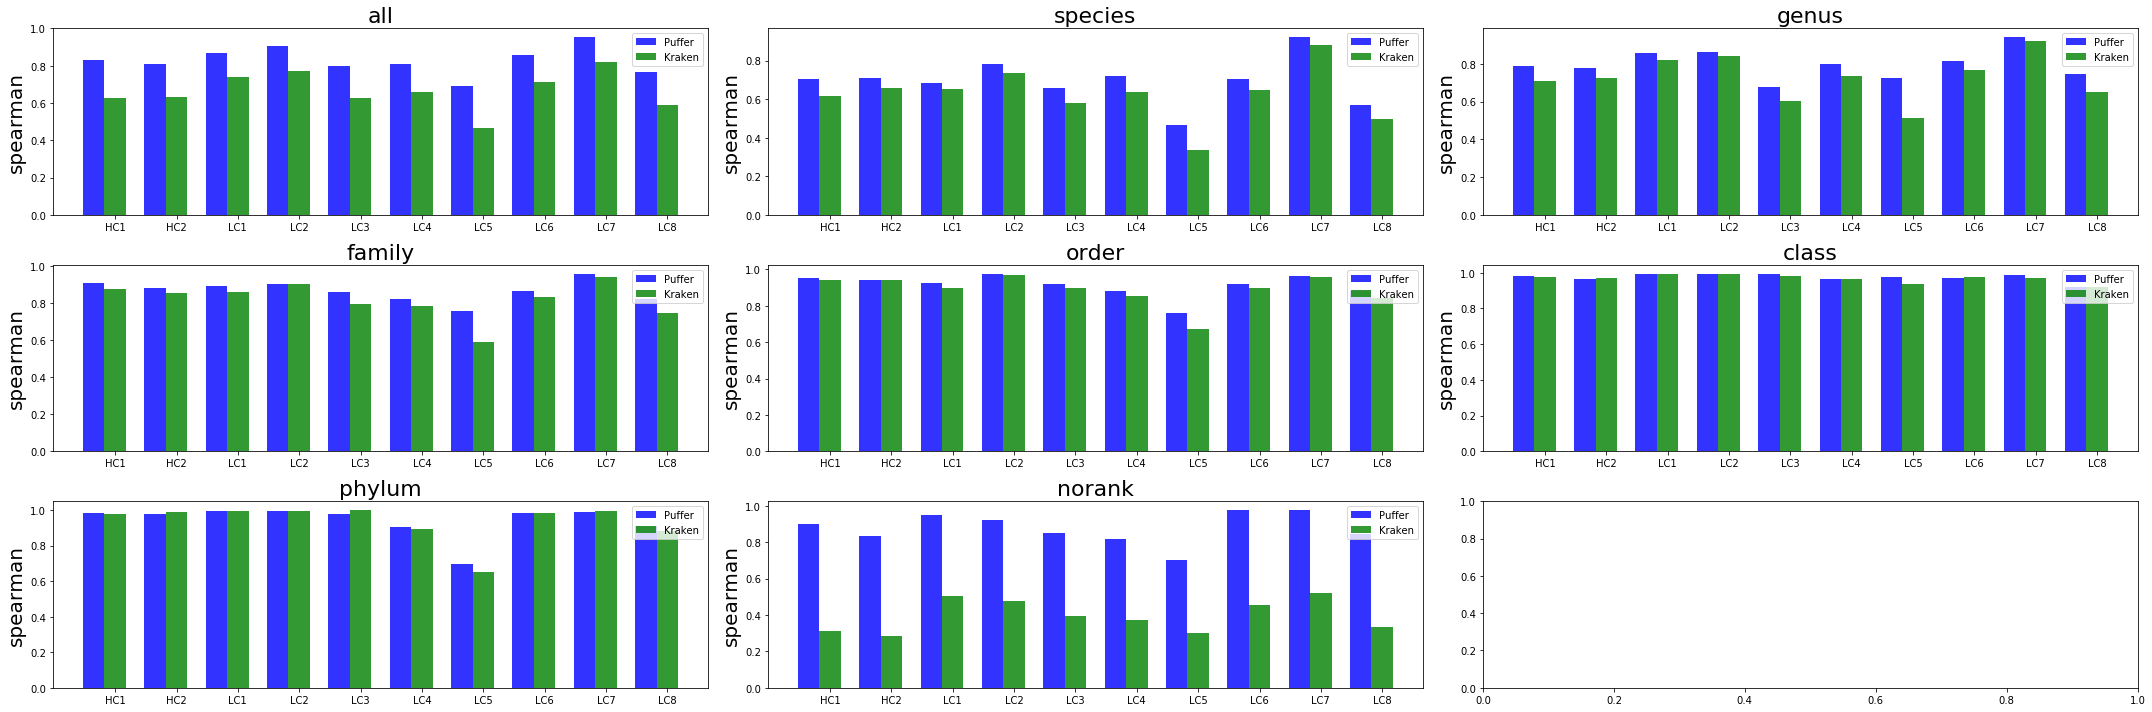



pearson


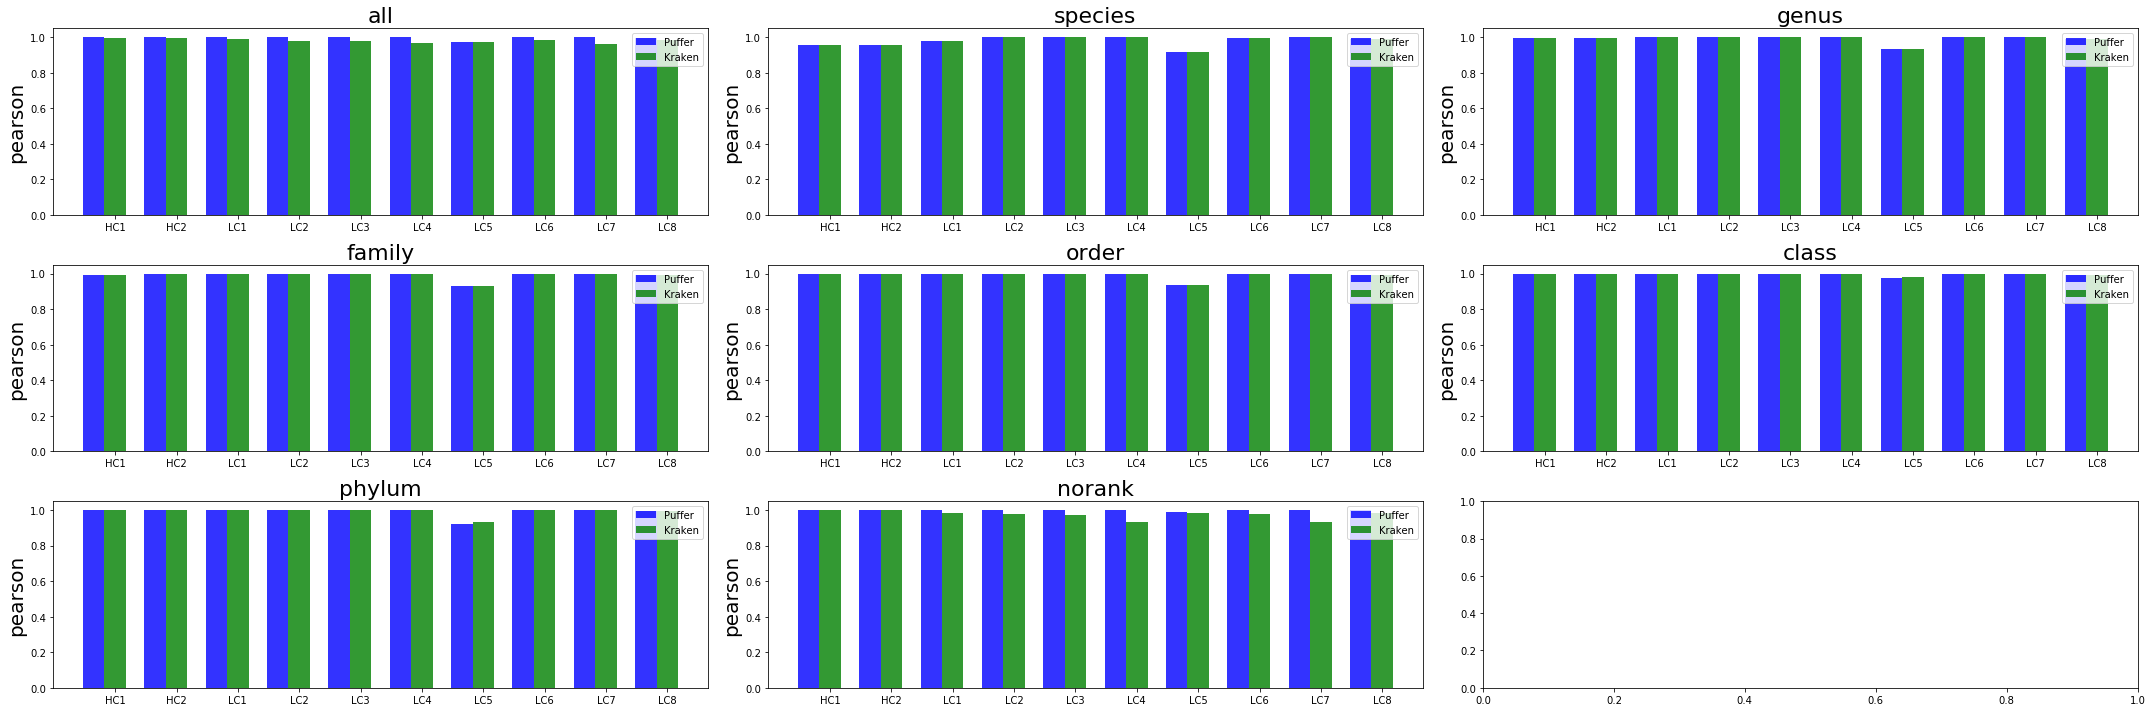



mard


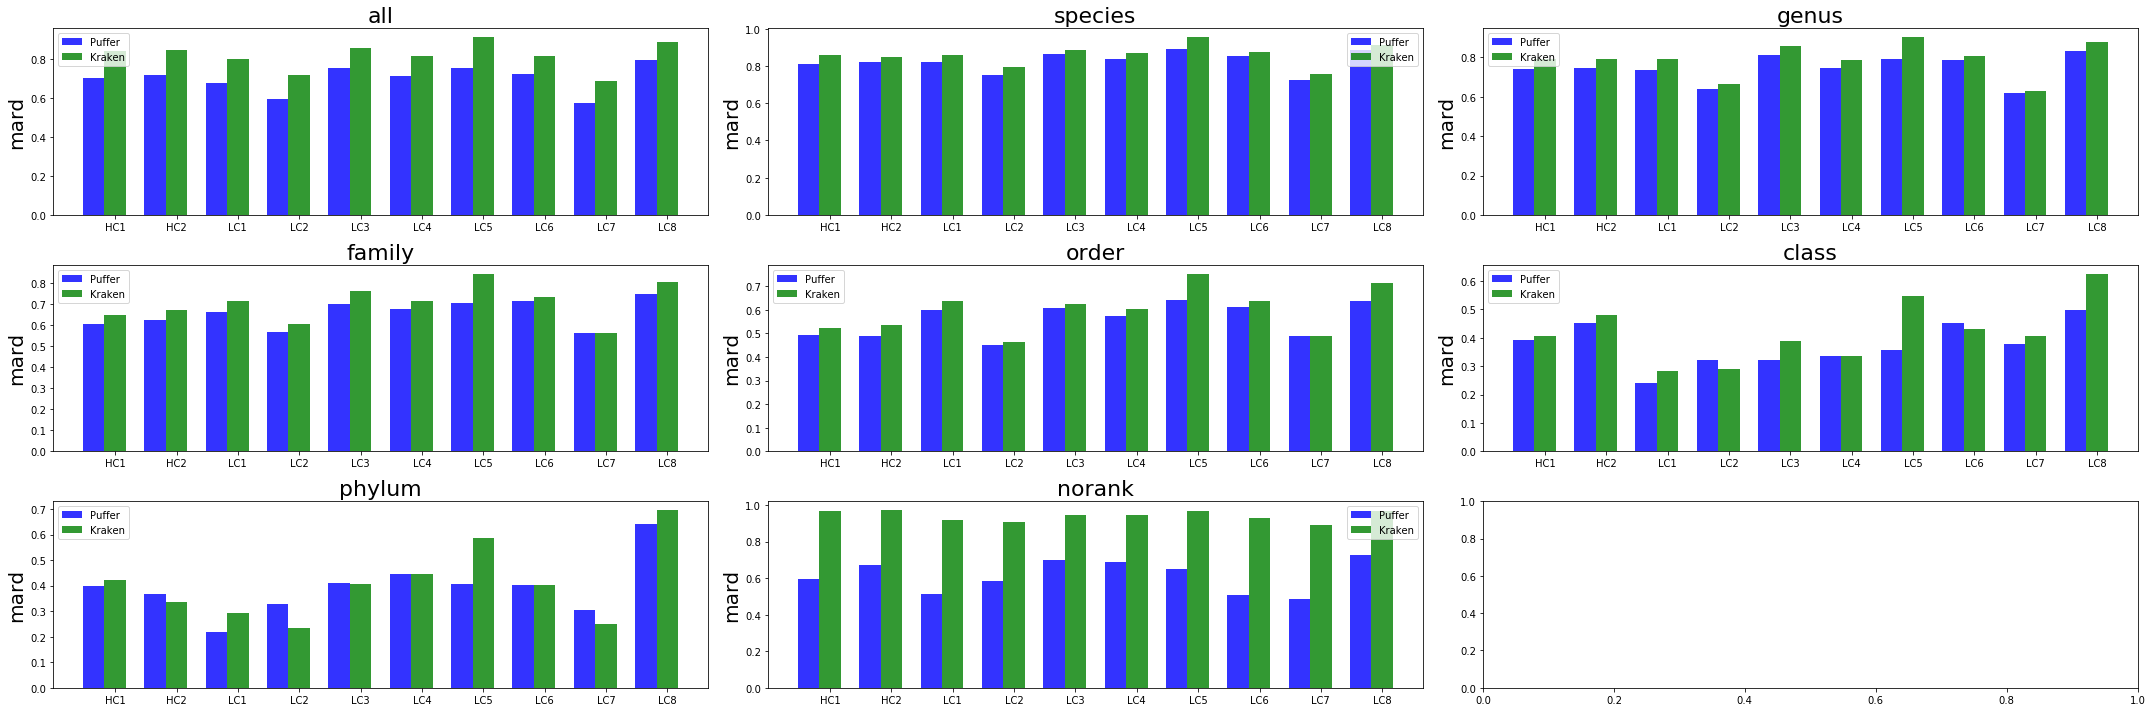



f1


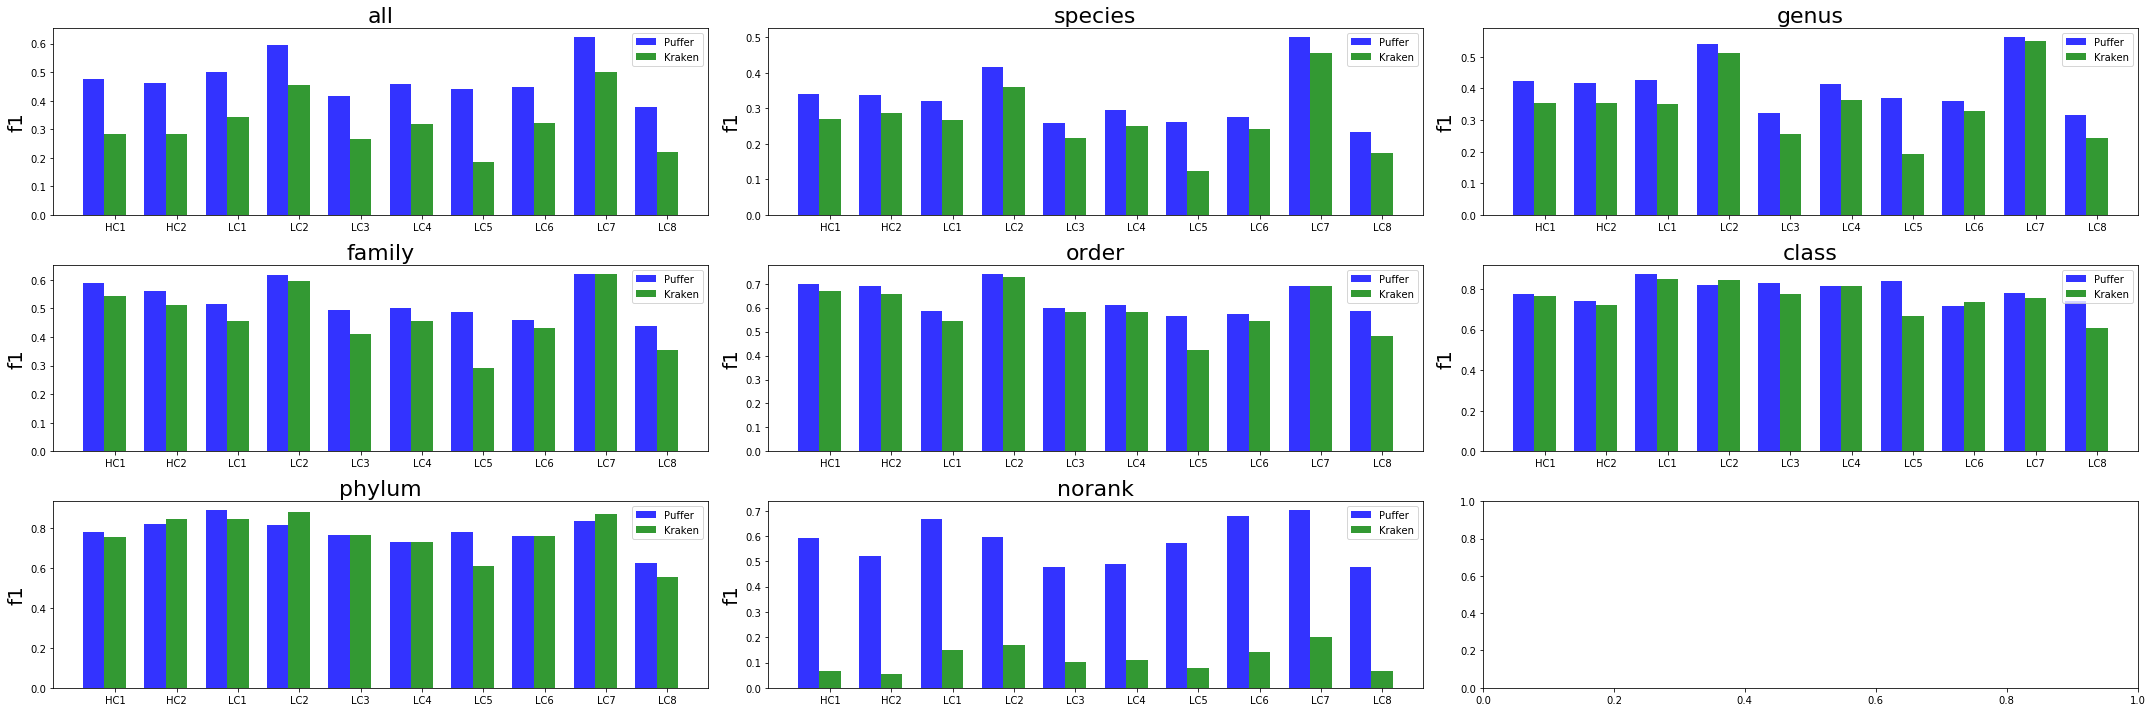



cnt_f1


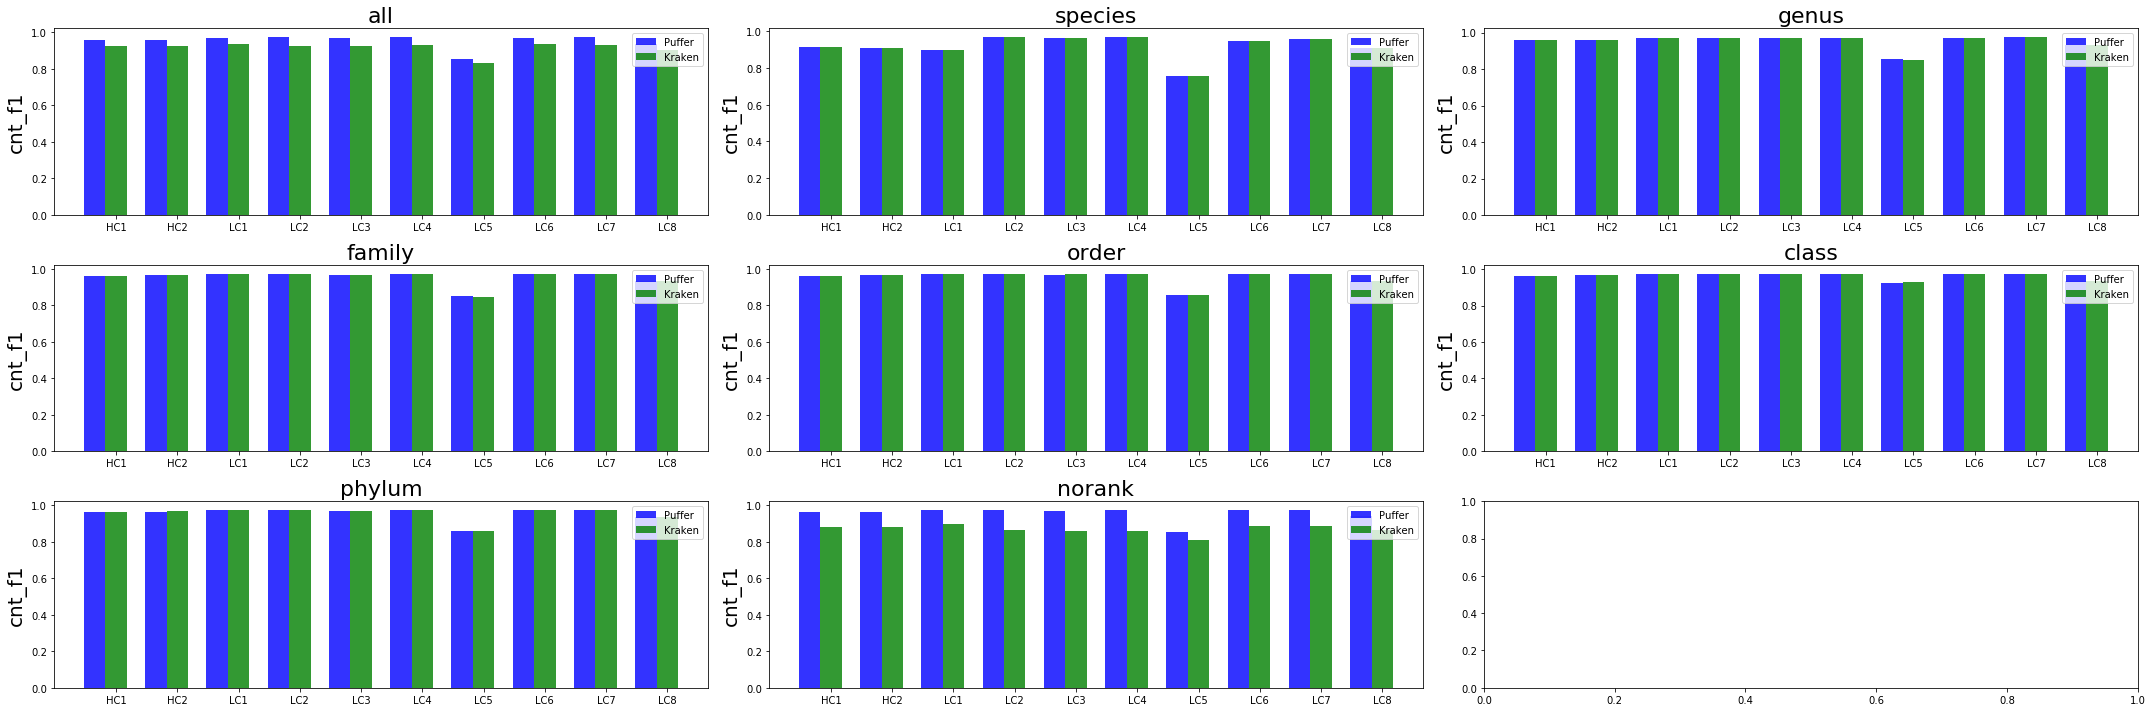

In [253]:
print("\n\nNo Filtering")
(stats_df, kraken, puffer) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
                                           '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}_unfilt.rpt', 
                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species_unfilt.out', 
                                     '/mnt/scratch2/fatemeh/krakpuff/statSummary/unfiltered.stat')
draw_plots(stats_df)
#stats_df

# Filter coverage less than 20 percent normalized by read len



20%
HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


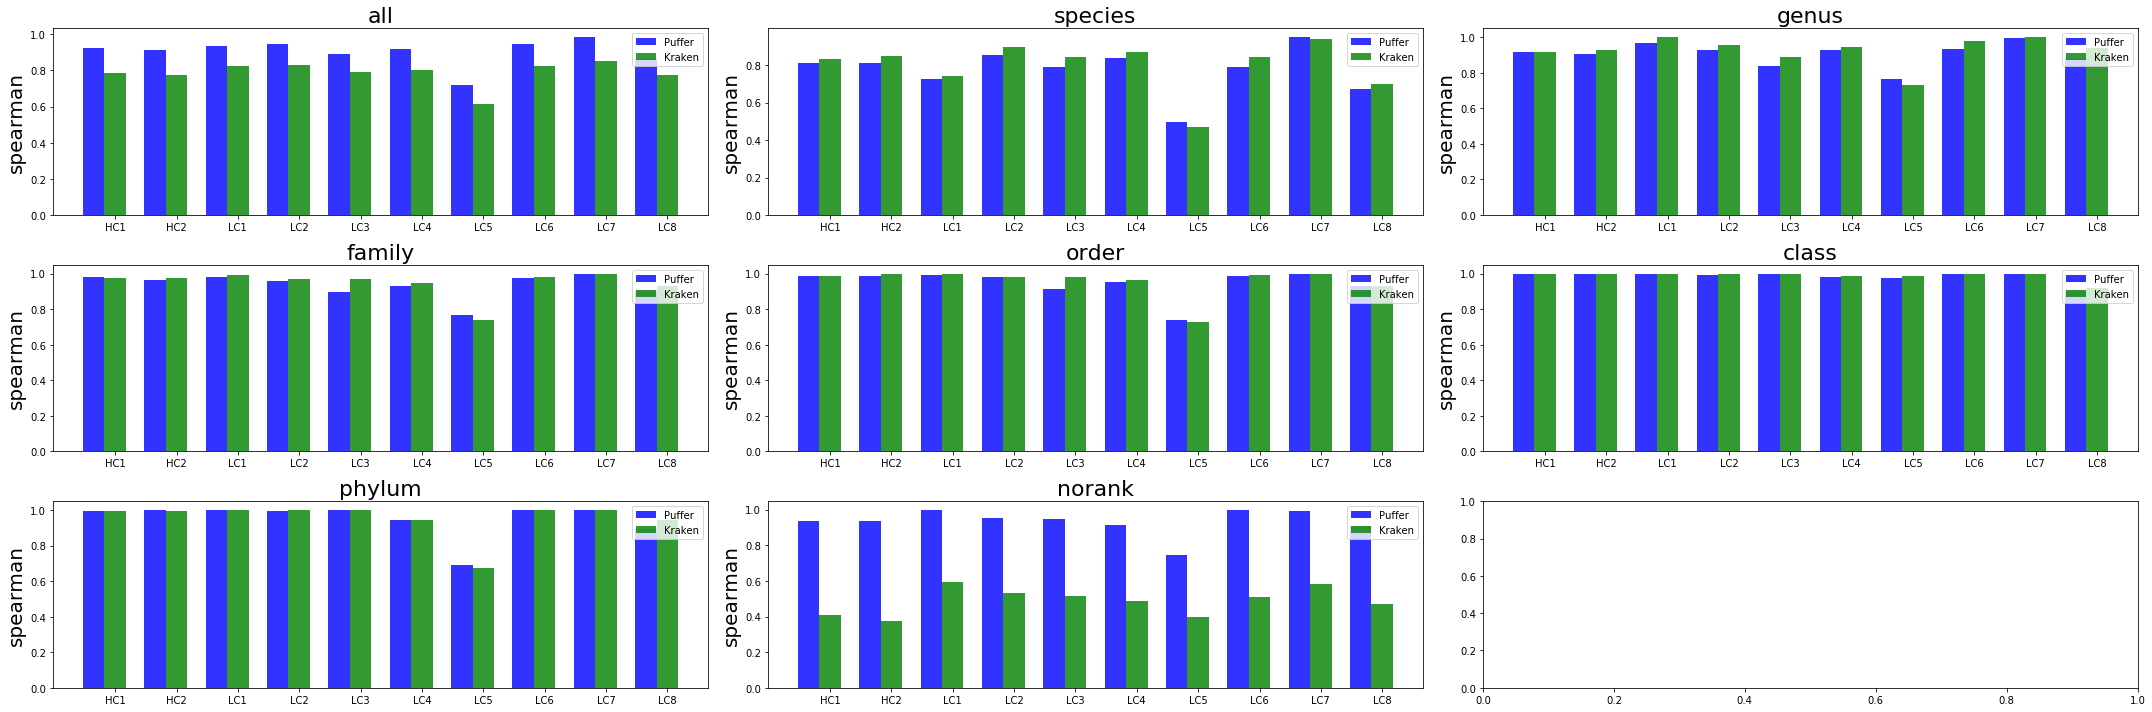



pearson


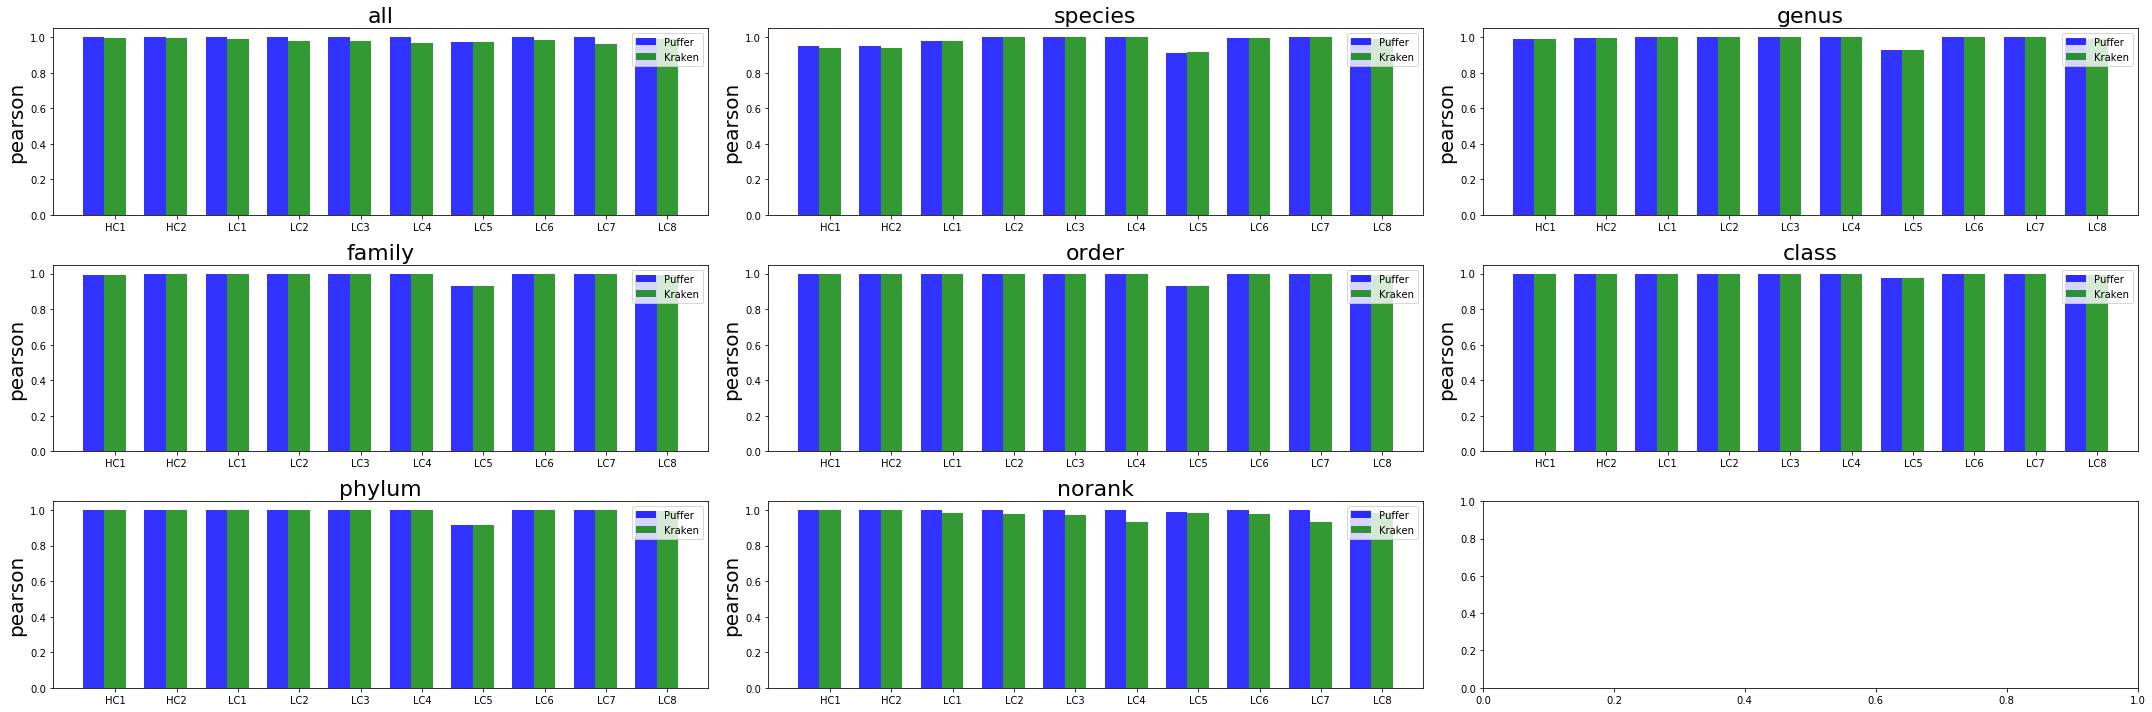



mard


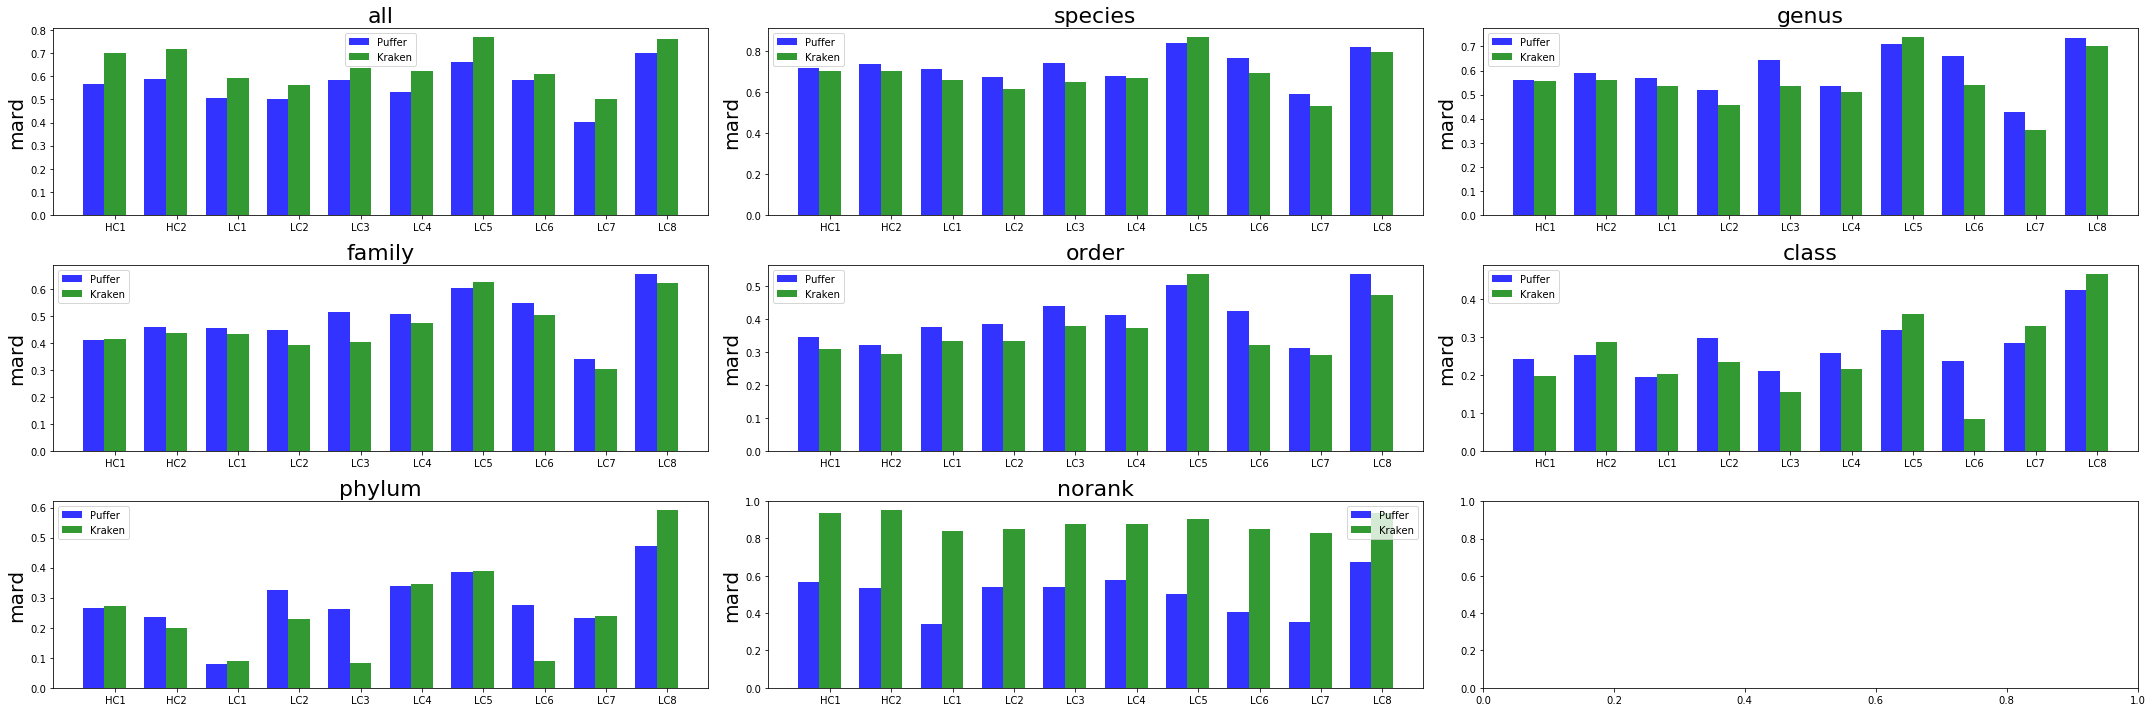



f1


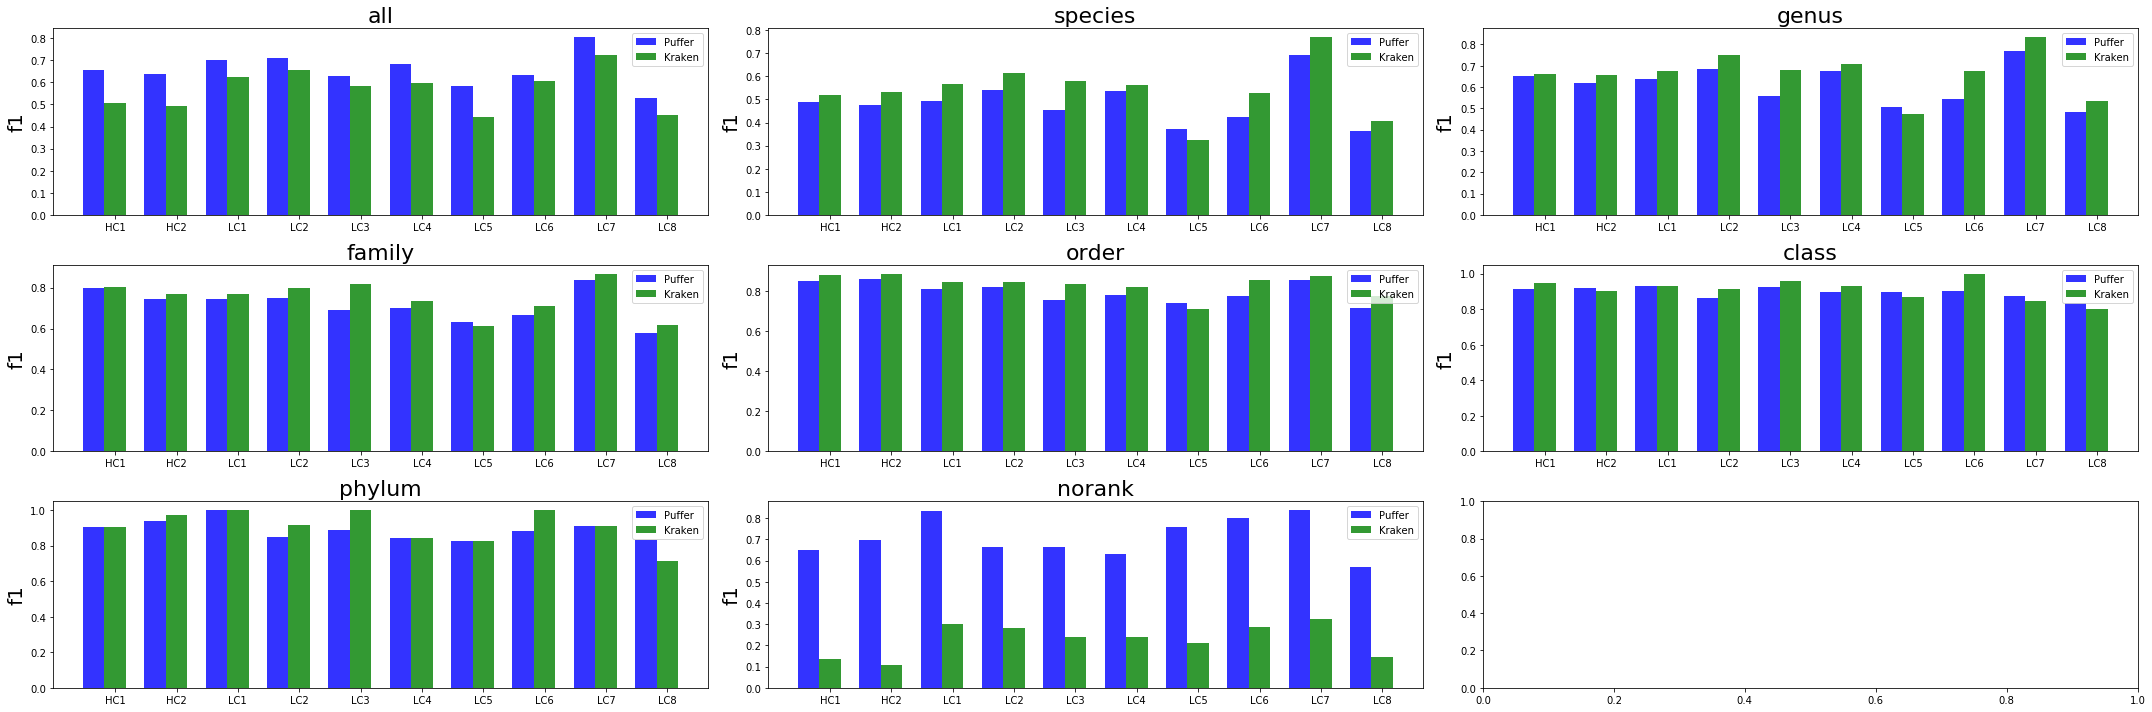



cnt_f1


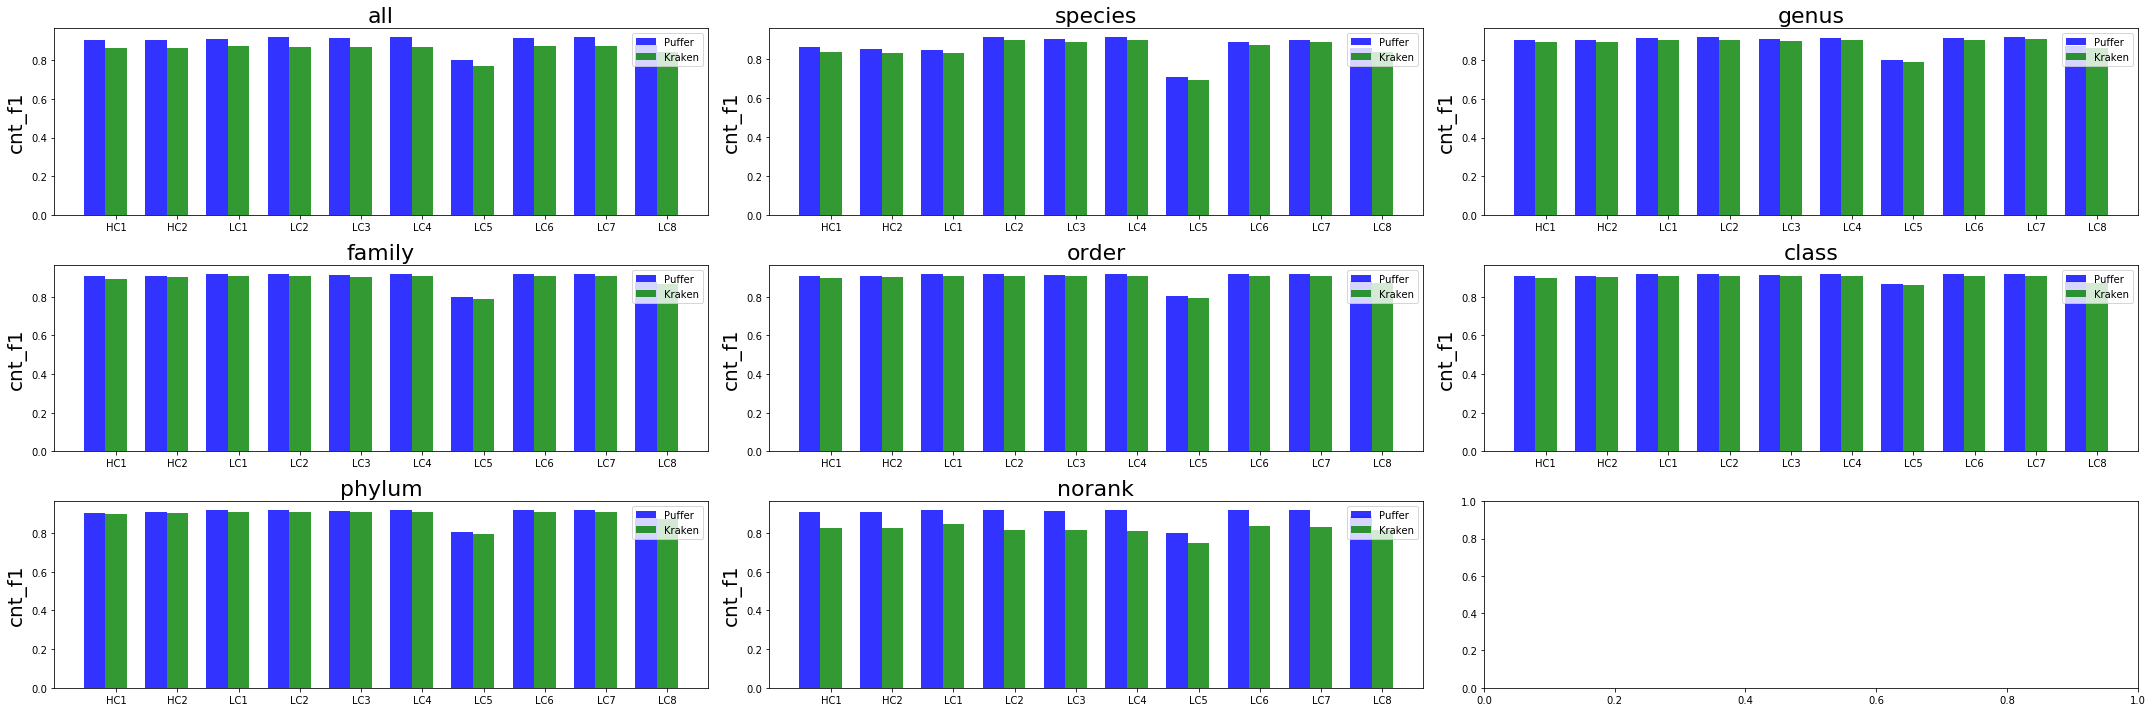

In [254]:
print("\n\n20%")
(stats20_df, kraken20, puffer20) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
                                           '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out', 
                                    '/mnt/scratch2/fatemeh/krakpuff/statSummary/puff20_krak20.stat')
draw_plots(stats20_df)

# Filter coverage less than 44 nucleotides



44Nuc
HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


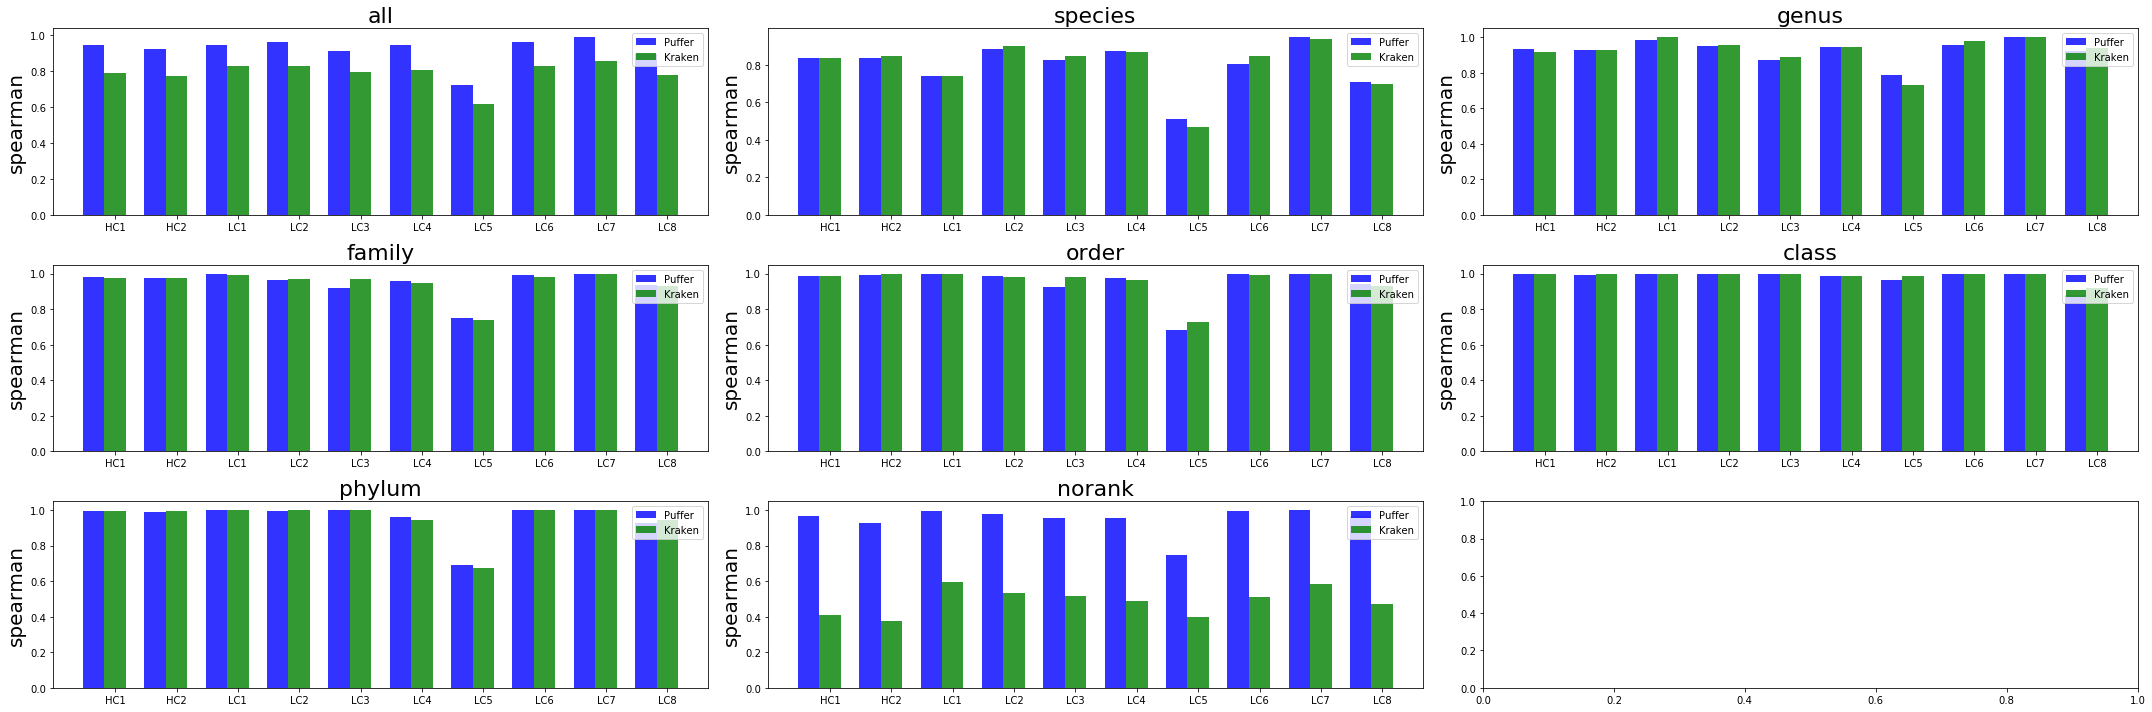



pearson


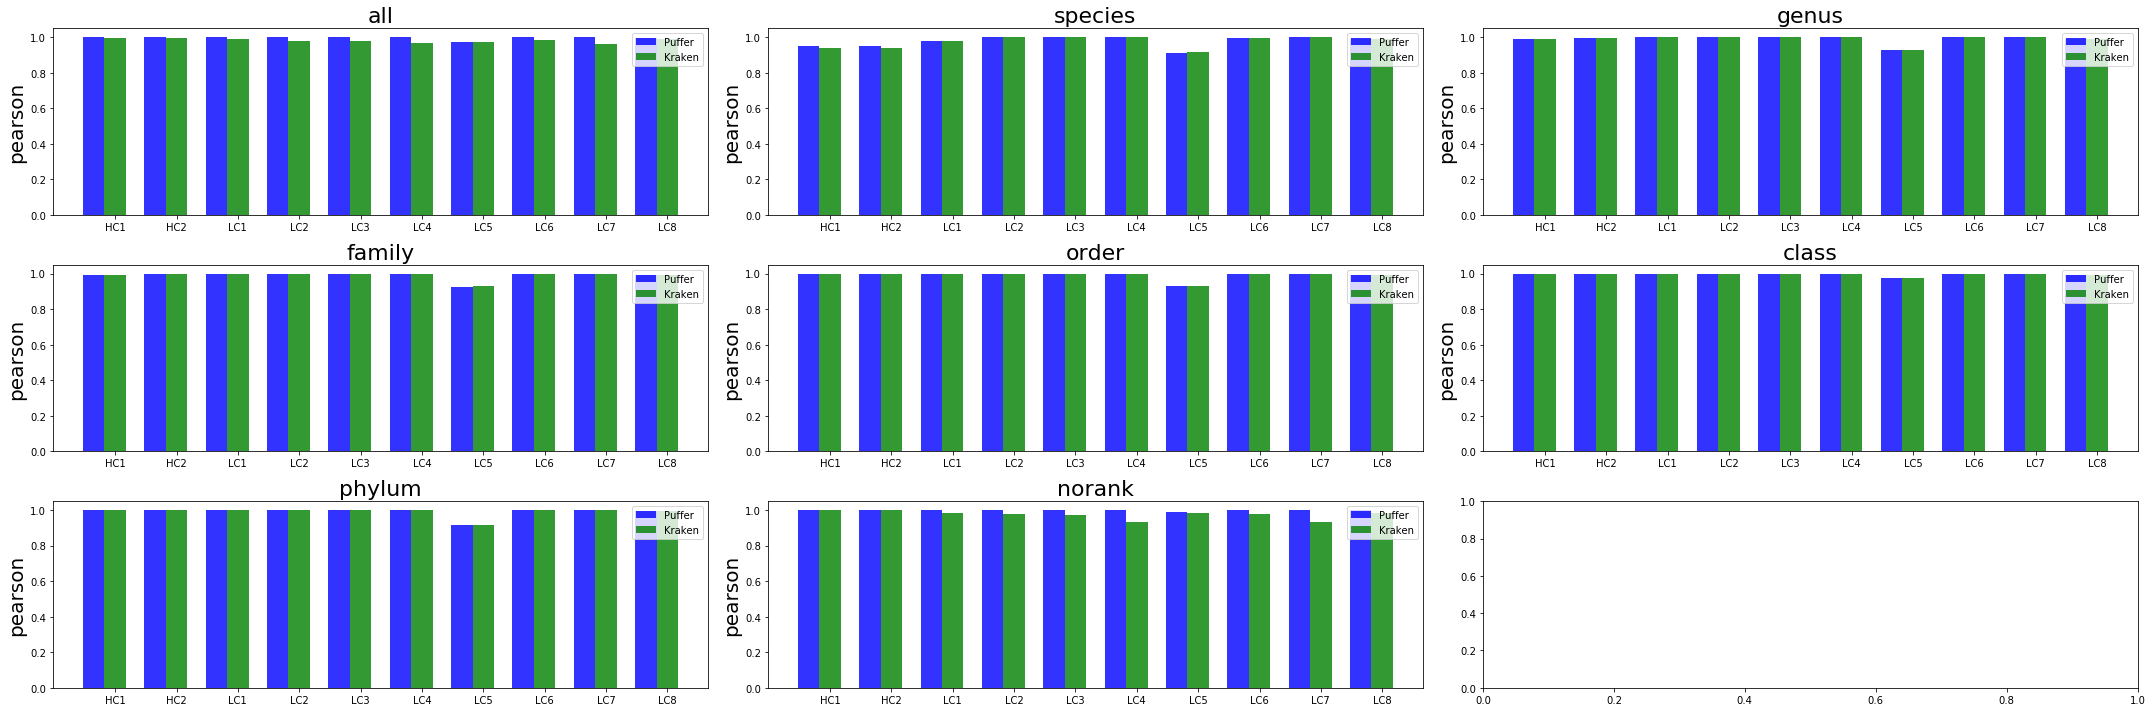



mard


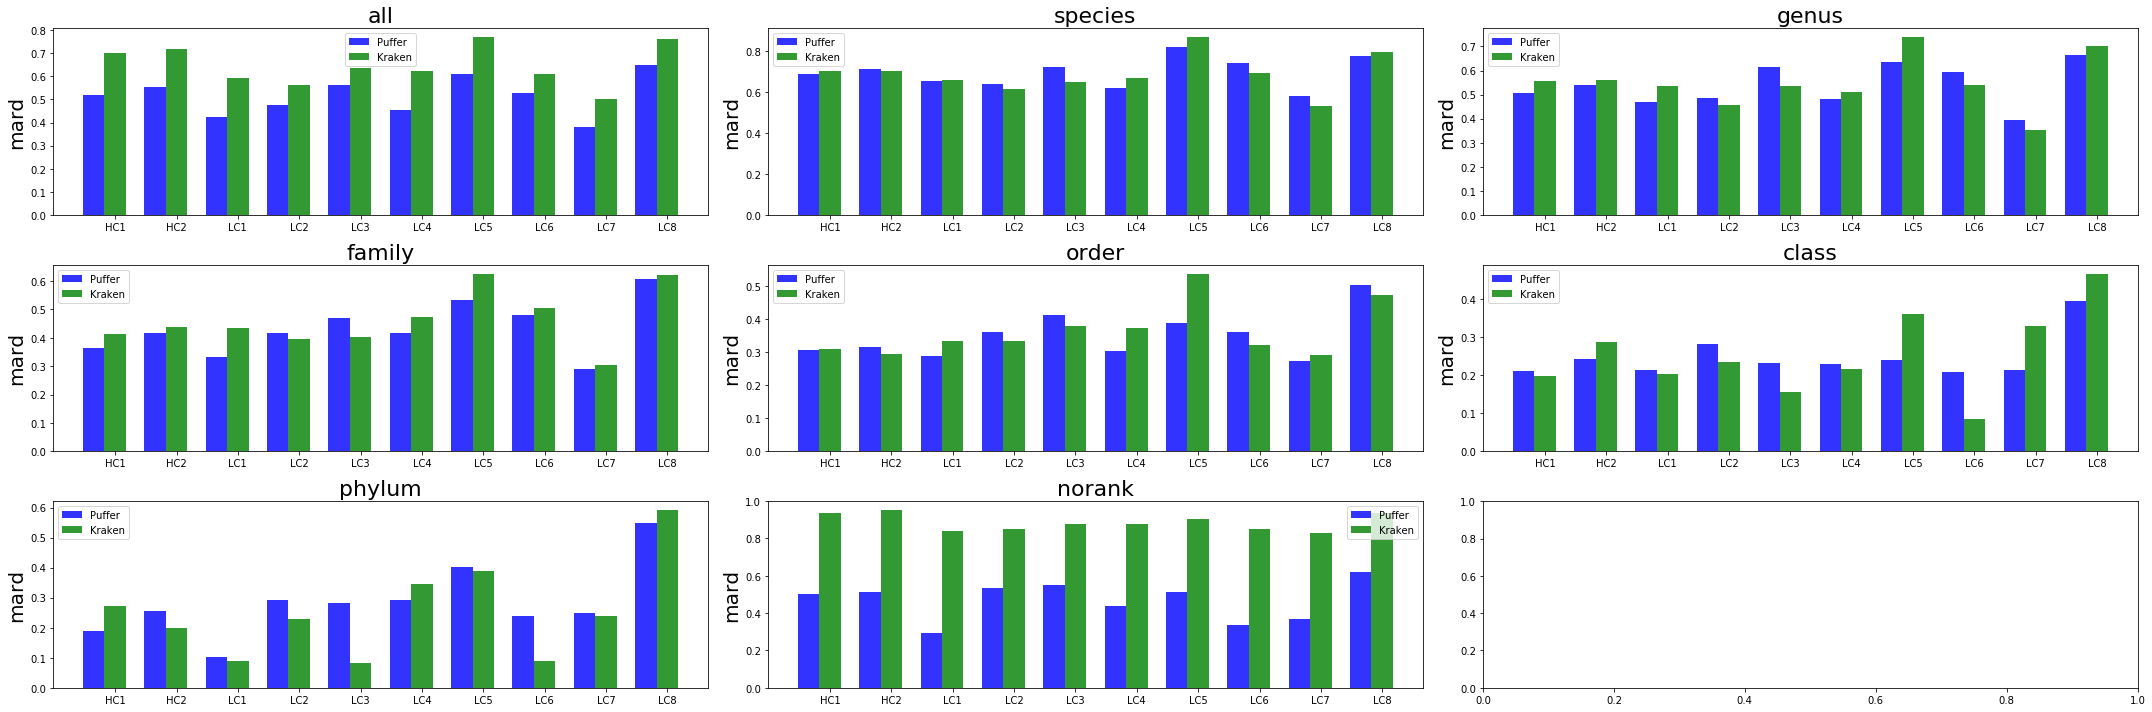



f1


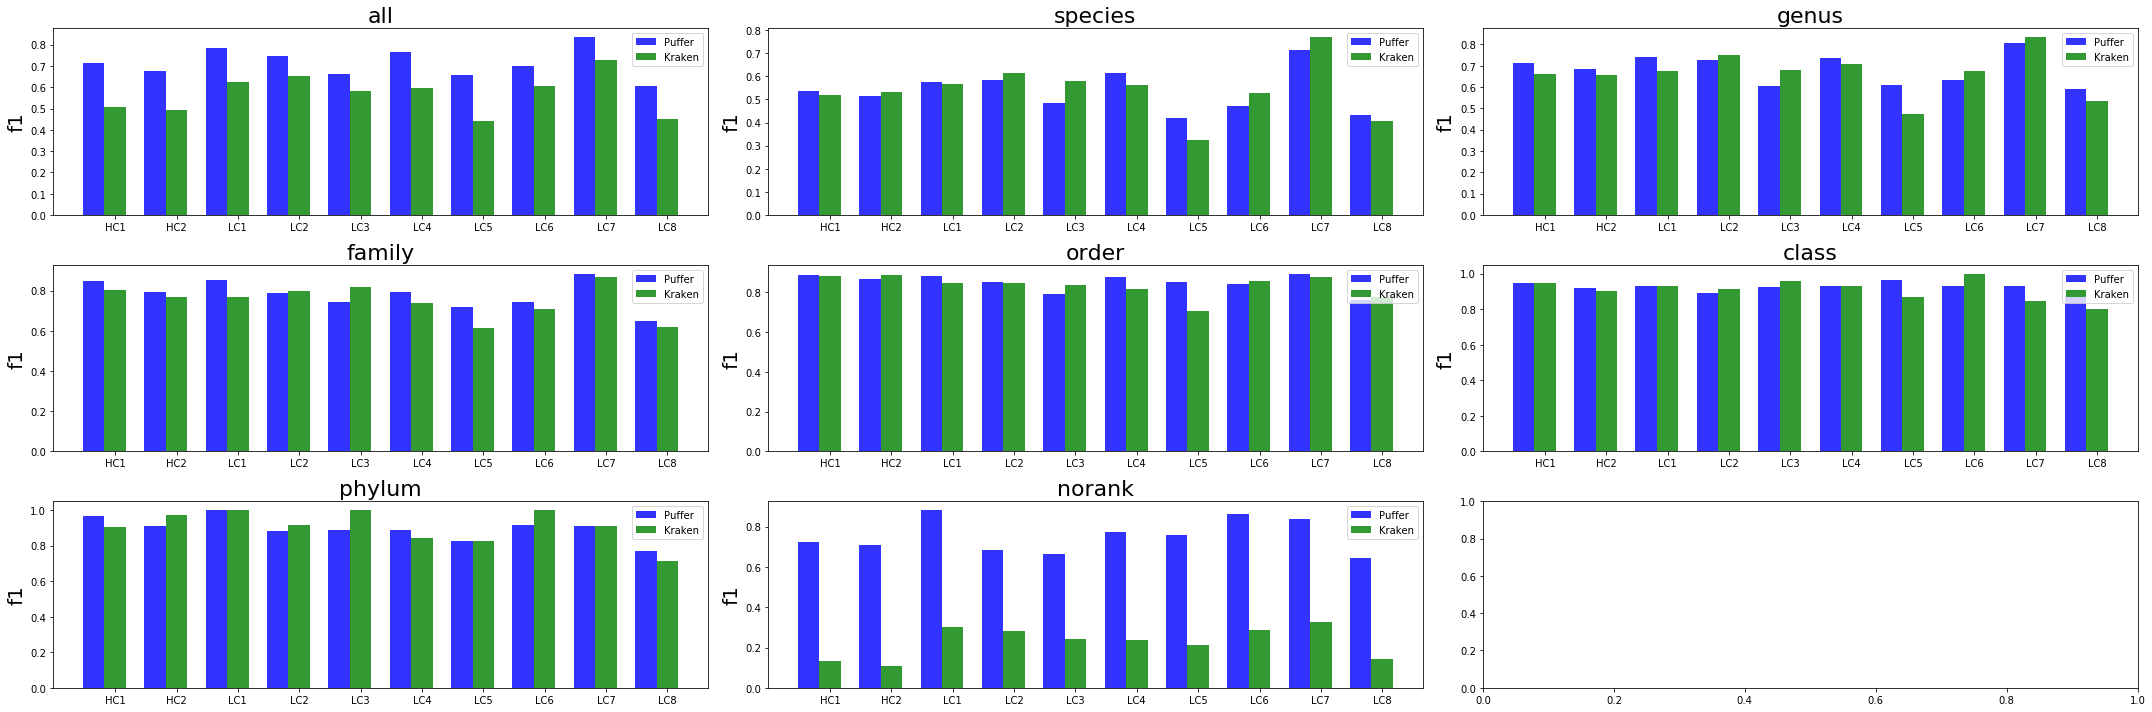



cnt_f1


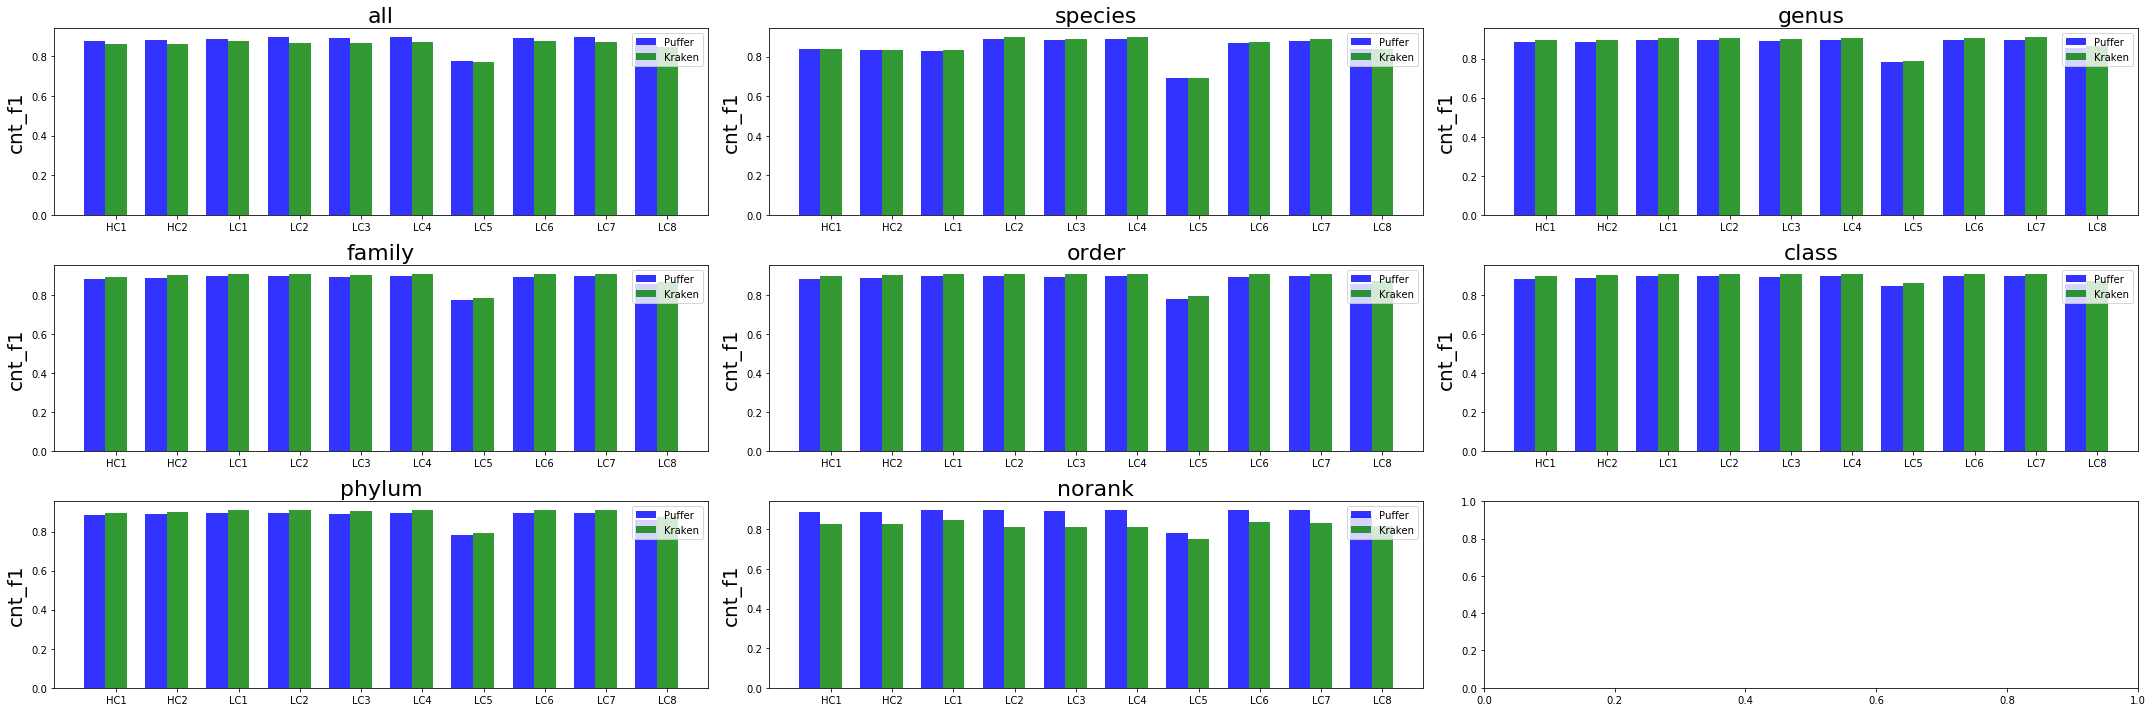

In [255]:
print("\n\n44Nuc")
(stats44_df, kraken20, puffer44) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
                                           '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                           '/mnt/scratch2/fatemeh/krakpuff/{}_species44.out', 
                                    '/mnt/scratch2/fatemeh/krakpuff/statSummary/puff44_krak20.stat')
draw_plots(stats44_df)
#stats44_df

In [217]:
a = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/before_debug/unfiltered.stat')
b = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/no_repeated_ref/unfiltered.stat')
c = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/skip1/unfiltered.stat')
d = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/unfiltered.stat')

In [201]:
a.head(6)

,dataset,level,puff_pearson,puff_spearman,puff_mard,puff_cnt_prec,puff_cnt_rec,puff_cnt_f1,puff_prec,puff_rec,...,kraken_cnt_rec,kraken_cnt_f1,kraken_prec,kraken_rec,kraken_f1,krakpuff_mard_diff,puffkrak_spearman_diff,puffkrak_pearson_diff,puffkrak_cnt_f1_diff,puffkrak_f1_diff
0,HC1,all,0.999726,0.819785,0.713138,0.999760,0.918042,0.957160,0.305651,0.986188,...,0.919683,0.923420,0.165431,0.986188,0.283333,0.131168,0.191755,0.001221,0.033740,0.183333
1,HC1,species,0.956346,0.691920,0.820025,0.998595,0.843147,0.914311,0.197154,0.970000,...,0.844487,0.914554,0.156200,0.970000,0.269071,0.037050,0.073275,-0.001967,-0.000243,0.058632
2,HC1,genus,0.993907,0.774309,0.749951,0.999484,0.922207,0.959292,0.260417,0.974026,...,0.922971,0.959371,0.217391,0.974026,0.355450,0.041006,0.065952,-0.000188,-0.000079,0.055509
3,HC1,family,0.994245,0.904803,0.609469,0.999776,0.923717,0.960242,0.416149,1.000000,...,0.924990,0.960815,0.374302,1.000000,0.544715,0.038910,0.029599,-0.000270,-0.000573,0.043004
4,HC1,order,0.996273,0.950263,0.492391,0.999899,0.924848,0.960910,0.539326,1.000000,...,0.926405,0.961725,0.505263,1.000000,0.671329,0.031526,0.009694,-0.000160,-0.000814,0.029401
5,HC1,class,0.999387,0.979559,0.392751,0.999974,0.925808,0.961463,0.634146,1.000000,...,0.927662,0.962456,0.619048,1.000000,0.764706,0.014195,0.005669,-0.000015,-0.000993,0.011414


In [246]:
kkk = c.puff_mard-b.puff_mard
kkk[kkk != 0]

0     0.019160
1     0.013405
2     0.017190
3     0.018631
4     0.026917
5     0.053939
6     0.092662
7     0.011009
8     0.007769
9     0.013136
10    0.015578
11    0.011574
12   -0.000024
13   -0.000019
14    0.032237
15    0.020543
16    0.025137
17    0.023831
18    0.024594
19    0.137690
20    0.222695
21   -0.000271
22    0.017137
23   -0.005662
24   -0.008366
25   -0.000497
26   -0.030833
27   -0.044688
28    0.022110
29    0.007670
        ...   
40   -0.038124
41   -0.044209
42    0.011825
43    0.007413
44    0.006312
45    0.022841
46    0.008073
47   -0.037894
48   -0.000070
49    0.010580
50    0.002042
51    0.013028
52    0.004120
53    0.021726
54    0.020855
55   -0.000244
56   -0.045677
57   -0.037883
58   -0.046723
59   -0.037429
60   -0.041545
61    0.000091
62   -0.053435
63    0.008436
64    0.002865
65    0.006488
66    0.015254
67    0.022575
68    0.000043
69   -0.035659
Name: puff_mard, Length: 70, dtype: float64

In [188]:
after_bug = {}
with open('/mnt/scratch2/fatemeh/krakpuff/mapping_dmps/LC4.dmp') as f:
    line = f.readline()
    while line:
        splitted = line.split()
        l = []
        for i in range(int(splitted[1])):
            line = f.readline()
            l += [line.split()[0]]
        #if (splitted[0] in after_bug):
        #    print('shouldnt {}'.format(splitted[0]))
        after_bug[splitted[0]] = l
        line = f.readline()       

In [191]:
before_bug = {}
with open('/mnt/scratch2/LC4.dmp') as f:
    line = f.readline()
    while line:
        splitted = line.split()
        l = []
        for i in range(int(splitted[1])):
            line = f.readline()
            l += [line.split()[0]]
        before_bug[splitted[0]] = l
        line = f.readline()

In [192]:
for k, v in after_bug.items():
    if len(before_bug[k]) != len(v):
        print('{}:{},{}'.format(k, len(before_bug[k]), len(v)))

pzu_111491_111670_8e62b:0,1
pzu_2703637_2703793_153bd:0,1
pzu_1255774_1255944_3d32d:0,1
pzu_2945802_2945978_2dd40:1,0
pzu_1484500_1484678_89975:0,1
pzu_2750703_2750884_36398:1,0
pzu_3324642_3324789_706ef:1,0
pzu_68754_68901_60ed6:0,1
pzu_1563937_1564121_118dc:0,1
pzu_1211775_1211974_252b3:0,1
pzu_3540931_3541097_a019d:0,1
pzu_1926279_1926470_2218b:2,1
har_1949026_1949213_198c9:1,0
xca_294301_294475_7dd0:2,1
pzu_1676826_1676998_4d651:1,0


In [193]:
print(after_bug['pzu_111491_111670_8e62b'])
print(before_bug['pzu_111491_111670_8e62b'])

['gi|197103466|ref|NC_011144.1|']
[]


In [ ]:
clark_hc1 = pd.read_csv('/mnt/scratch2/avi/meta-map/clark/HC1.rpt')

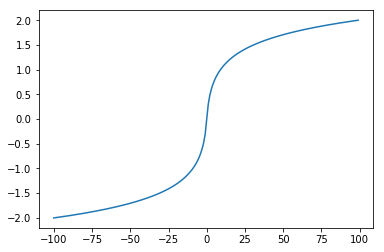

In [243]:
def sign(a):
    if a > 0:
        return 1
    if a <= 0:
        return -1
difference = list(range(-100, 100, 1))

log_modulus = [sign(x)*log(abs(x)+1, 10) for x in difference]
plt.plot(difference, log_modulus)